# Crop Yield Prediction: PyTorch LSTM with Optuna (Part 5)

## Overview
This notebook trains a **Long Short-Term Memory (LSTM) Network** to predict crop yields using time-series data. LSTMs are specialized for sequential data, allowing the model to learn temporal dependencies and historical trends better than standard Feedforward Networks.

## Methodology
1.  **Crop Selection:** Choose the specific crop to predict.
2.  **Feature Analysis:** Review the input variables.
3.  **Sequence Generation:** Transform tabular data into time-series sequences (e.g., using the last N years to predict the next year).
4.  **Time-Series Split:** Divide sequences by year:
    * **Train:** Learn patterns.
    * **Validation:** Tune settings.
    * **Test:** Final evaluation.
5.  **Data Scaling:** Normalize features for Neural Network stability.
6.  **Baseline:** Compare against a simple guess (Last Year's Yield).
7.  **Initial Model:** Train a default LSTM model and check learning curves.
8.  **Optimization:** Use **Optuna** to find the best LSTM architecture (hidden size, layers) and hyperparameters.
9.  **Final Evaluation:** Compare accuracy (RMSE) across all stages.

In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau  # <--- NEW: For learning rate decay
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# Optuna Visualization Tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### 1. Data Preparation and Crop Choice
We load the main dataset and identify the available crops. For this analysis, we focus specifically on **Rice**. We clean the data by removing columns related to other crops and deleting any rows where the target yield information is missing.

In [25]:
# Load dataset
df = pd.read_parquet('Parquet/XY_v2.parquet')

# --- LIST AVAILABLE CROPS ---
# Assumes targets start with 'Y_'
target_columns = [col for col in df.columns if col.startswith('Y_')]
available_crops = [col.replace('Y_', '') for col in target_columns]

print("--- Available Crops found in Dataset ---")
print(available_crops)
print("-" * 40)

# --- CONFIGURATION: SET CROP HERE ---
CHOSEN_CROP = 'rice'  # <--- CHANGE THIS to 'lettuce', 'pepper', etc. based on list above
# ------------------------------------

# Define Target and Dynamic Lag Features
TARGET_COL = f'Y_{CHOSEN_CROP}'
LAG_1_FEATURE = f'avg_yield_{CHOSEN_CROP}_1y'

if TARGET_COL not in df.columns:
    raise ValueError(f"Target {TARGET_COL} not found in dataset. Check spelling.")

print(f"Predicting Target: {TARGET_COL}")
print(f"Using Lag 1 Feature: {LAG_1_FEATURE}")

# Clean Missing Targets for the chosen crop
df_model = df.dropna(subset=[TARGET_COL])

print(f"Data Loaded. Rows with valid target: {len(df_model)}")

--- Available Crops found in Dataset ---
['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']
----------------------------------------
Predicting Target: Y_rice
Using Lag 1 Feature: avg_yield_rice_1y
Data Loaded. Rows with valid target: 4729


### 2. Sequence Generation, Splitting, and Scaling
For LSTMs, we cannot just use raw rows. We must create **sequences** (time windows). For example, use data from years $t-2, t-1, t$ to predict yield at $t+1$.

1.  **Scaling:** Fit scaler on training years only, transform everything.
2.  **Sequence Creation:** Group data by 'area', sort by 'year', and create sliding windows.
3.  **Splitting:** Assign sequences to Train/Val/Test based on the year of the *target* value.

In [26]:
import numpy as np
import pandas as pd
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# -------------------------------
# 0. DEVICE
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------
# 1. DROP UNWANTED COLUMNS
# -------------------------------
cols_to_drop = [c for c in df_model.columns 
                if c.startswith("avg_yield_") and CHOSEN_CROP not in c]
df_model = df_model.drop(columns=cols_to_drop)

feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and c not in ['area']]

print(f"Total Features Used: {len(feature_cols)}")
display(pd.DataFrame(feature_cols, columns=['Feature Name']).T)

# -------------------------------
# 2. IMPUTATION & SCALING
# -------------------------------
TRAIN_END_YEAR = 2012  # only used for fitting imputer/scaler

train_mask_impute = df_model['year'] < TRAIN_END_YEAR
imputer = SimpleImputer(strategy='mean')
imputer.fit(df_model.loc[train_mask_impute, feature_cols])
df_model[feature_cols] = imputer.transform(df_model[feature_cols])

scaler = StandardScaler()
scaler.fit(df_model.loc[train_mask_impute, feature_cols])
df_model[feature_cols] = scaler.transform(df_model[feature_cols])

# -------------------------------
# 3. SEQUENCE GENERATION FUNCTION
# -------------------------------
SEQUENCE_LENGTH = 2  # look-back

def create_time_series_data(df, features, target, seq_len=2):
    sequences = []
    targets = []
    areas = []

    for area, group in df.groupby('area'):
        group = group.sort_values('year')
        data = group[features].values
        labels = group[target].values

        for i in range(len(data) - seq_len):
            seq = data[i:i+seq_len]
            label = labels[i+seq_len]

            sequences.append(seq)
            targets.append(label)
            areas.append(area)

    return np.array(sequences), np.array(targets), np.array(areas)

X_seq, y_seq, y_areas = create_time_series_data(df_model, feature_cols, TARGET_COL, SEQUENCE_LENGTH)
print(f"Total sequences generated: {len(X_seq)}")
print(f"Sequence shape: {X_seq.shape}")

# -------------------------------
# 4. TRAIN/VAL/TEST SPLIT (chronological)
# -------------------------------
# Determine split indices
total_samples = len(X_seq)
train_end = int(0.7 * total_samples)
val_end = int(0.85 * total_samples)

X_train = X_seq[:train_end]
y_train = y_seq[:train_end]
areas_train = y_areas[:train_end]

X_val = X_seq[train_end:val_end]
y_val = y_seq[train_end:val_end]
areas_val = y_areas[train_end:val_end]

X_test = X_seq[val_end:]
y_test = y_seq[val_end:]
areas_test = y_areas[val_end:]

print(f"\nTrain samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# -------------------------------
# 5. CONVERT TO PYTORCH TENSORS
# -------------------------------
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

print(f"\nInput shape for model (batch, seq_len, features): {X_train_tensor.shape}")


Total Features Used: 23


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
Feature Name,year,avg_yield_rice_1y,avg_yield_rice_3y,avg_yield_rice_5y,sum_rain_winter,sum_rain_spring,sum_rain_summer,sum_rain_autumn,sum_rain_annual,avg_solar_winter,...,avg_solar_annual,avg_temp_winter,avg_temp_spring,avg_temp_summer,avg_temp_autumn,avg_temp_annual,pesticides_lag1,fertilizer_lag1,latitude,longitude


Total sequences generated: 4481
Sequence shape: (4481, 2, 23)

Train samples: 3136
Validation samples: 672
Test samples: 673

Input shape for model (batch, seq_len, features): torch.Size([3136, 2, 23])


### 3. Setting a Baseline
To establish a baseline, we use the simple logic: `Yield(t) = Yield(t-1)`. 
*Note: We extract the actual previous year's yield from our sequences (last step of the sequence) to ensure fair comparison on the exact same indices.*

In [27]:
# Baseline: yield(t) = yield(t-1)
# In our sequences, the last time step (index -1) contains the features for t-1.
# We need to un-scale the 'avg_yield_rice_1y' feature to get the actual prediction in hg/ha.

# 1. Find index of lag-1 yield in feature list
lag1_idx = feature_cols.index(LAG_1_FEATURE)

# 2. Extract scaled t-1 values from Test sequences
y_pred_baseline_scaled = X_test[:, -1, lag1_idx] 

# 3. Inverse transform manually (since scaler expects all features)
mean_y = scaler.mean_[lag1_idx]
scale_y = scaler.scale_[lag1_idx]
y_pred_baseline = (y_pred_baseline_scaled * scale_y) + mean_y

rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"Baseline RMSE (Persistence): {rmse_baseline:.2f}")

Baseline RMSE (Persistence): 564.97


### 4. Initial Model Testing (LSTM)
We train a basic LSTM network. The model takes a sequence of features as input and outputs a single yield prediction.

Epoch 0/300 | Train RMSE: 3956.49 | Val RMSE: 4371.43
Epoch 20/300 | Train RMSE: 3432.64 | Val RMSE: 3831.37
Epoch 40/300 | Train RMSE: 2980.67 | Val RMSE: 3351.37
Epoch 60/300 | Train RMSE: 2570.09 | Val RMSE: 2912.44
Epoch 80/300 | Train RMSE: 2206.88 | Val RMSE: 2514.99
Epoch 100/300 | Train RMSE: 1885.22 | Val RMSE: 2161.50
Epoch 120/300 | Train RMSE: 1606.57 | Val RMSE: 1855.75
Epoch 140/300 | Train RMSE: 1366.86 | Val RMSE: 1593.43
Epoch 160/300 | Train RMSE: 1166.65 | Val RMSE: 1379.26
Epoch 180/300 | Train RMSE: 994.95 | Val RMSE: 1200.15
Epoch 200/300 | Train RMSE: 848.34 | Val RMSE: 1079.41
Epoch 220/300 | Train RMSE: 733.01 | Val RMSE: 980.71
Epoch 240/300 | Train RMSE: 643.06 | Val RMSE: 969.51
Early stopping triggered at epoch 254


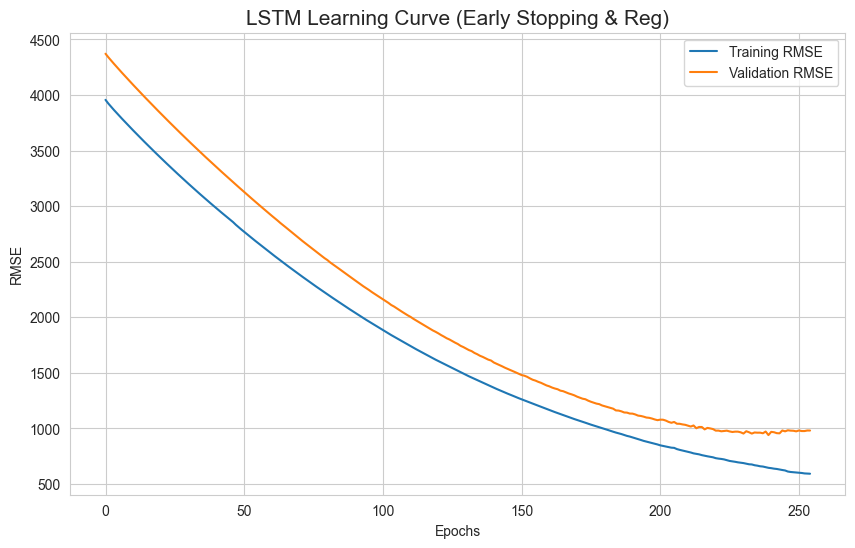

Initial LSTM Test RMSE: 1088.13


In [ ]:
# --- 1. EARLY STOPPING CLASS ---
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# --- 2. LSTM MODEL ---
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully Connected Output Layer
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# --- 3. TRAIN FUNCTION (FIXED) ---
def train_model(model, X_t, y_t, X_v, y_v, lr=0.01, epochs=300, batch_size=32, weight_decay=1e-4, verbose=True):
    criterion = nn.MSELoss()
    # Added weight_decay (L2 Regularization) to optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Scheduler: reduce LR if val loss stops dropping
    # REMOVED verbose=False to fix TypeError
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Early Stopping
    early_stopper = EarlyStopping(patience=15)
    
    train_loader = DataLoader(TensorDataset(X_t, y_t), batch_size=batch_size, shuffle=True)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
            
        train_mse = epoch_loss / len(X_t)
        train_rmse = np.sqrt(train_mse)
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_v)
            val_loss = criterion(val_outputs, y_v)
            val_rmse = np.sqrt(val_loss.item())
            
        train_losses.append(train_rmse)
        val_losses.append(val_rmse)
        
        # Update Scheduler and Check Early Stopping
        scheduler.step(val_rmse)
        early_stopper(val_rmse)
        
        if verbose and (epoch % 20 == 0 or epoch == epochs-1):
            print(f"Epoch {epoch}/{epochs} | Train RMSE: {train_rmse:.2f} | Val RMSE: {val_rmse:.2f}")
            
        if early_stopper.early_stop:
            if verbose: 
                print(f"Early stopping triggered at epoch {epoch}")
            break
            
    return train_losses, val_losses

# --- INITIAL TEST (SMALLER MODEL) ---
input_dim = X_train.shape[2]
# Reduced hidden_dim from 64 to 32 to prevent overfitting immediately
model_init = LSTMModel(input_dim=input_dim, hidden_dim=32, num_layers=1).to(device)

train_hist, val_hist = train_model(model_init, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

plt.figure(figsize=(10, 6))
plt.plot(train_hist, label='Training RMSE')
plt.plot(val_hist, label='Validation RMSE')
plt.title(f'LSTM Learning Curve (Early Stopping & Reg)', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

model_init.eval()
with torch.no_grad():
    y_pred_init_test = model_init(X_test_tensor).cpu().numpy().flatten()
print(f"Initial LSTM Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_init_test)):.2f}")

### 5. Tuning the Model (Optuna)
We use **Optuna** to automatically find the best LSTM architecture. We tune the hidden dimension, number of layers, dropout, and learning rate.

In [29]:
# --- OPTUNA OBJECTIVE FUNCTION (CONSTRAINED) ---
def objective(trial):
    # 1. Suggest Constrained Hyperparameters
    # Reduced max hidden_dim to 64 (was 256) to reduce model complexity
    hidden_dim = trial.suggest_int("hidden_dim", 16, 64)
    # Restricted layers to 1 or 2
    num_layers = trial.suggest_int("num_layers", 1, 2)
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 0.01, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    # Added Weight Decay suggestion for Regularization
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # 2. Build Model
    model = LSTMModel(input_dim, hidden_dim, num_layers, dropout).to(device)
    
    # 3. Setup Components
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    early_stopper = EarlyStopping(patience=15)
    
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), 
                              batch_size=batch_size, shuffle=True)
    
    # 4. Training Loop
    epochs = 100 
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_mse = criterion(val_pred, y_val_tensor).item()
            val_rmse = np.sqrt(val_mse)

        # Scheduler step
        scheduler.step(val_rmse)
        
        # Early Stopping check for pruning loop
        early_stopper(val_rmse)
        if early_stopper.early_stop:
            break

        # Optuna Pruning
        trial.report(val_rmse, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_rmse

# --- RUN OPTIMIZATION ---
study_name = f'{CHOSEN_CROP.capitalize()}_Yield_LSTM'
study = optuna.create_study(direction='minimize', study_name=study_name)
study.optimize(objective, n_trials=30)

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-11-29 17:01:55,780] A new study created in memory with name: Rice_Yield_LSTM
[I 2025-11-29 17:02:08,535] Trial 0 finished with value: 4404.906355417786 and parameters: {'hidden_dim': 16, 'num_layers': 2, 'dropout': 0.4245901124417155, 'lr': 0.00012057415829875067, 'batch_size': 128, 'weight_decay': 2.2517617613157168e-05}. Best is trial 0 with value: 4404.906355417786.
[I 2025-11-29 17:02:21,499] Trial 1 finished with value: 4383.210010939471 and parameters: {'hidden_dim': 25, 'num_layers': 2, 'dropout': 0.4948665033683589, 'lr': 0.00030501595901883343, 'batch_size': 128, 'weight_decay': 8.589676854411747e-05}. Best is trial 1 with value: 4383.210010939471.
[I 2025-11-29 17:02:47,444] Trial 2 finished with value: 3443.883128098281 and parameters: {'hidden_dim': 42, 'num_layers': 1, 'dropout': 0.21156245985396185, 'lr': 0.0027614179753252077, 'batch_size': 32, 'weight_decay': 1.093486542375355e-06}. Best is trial 2 with value: 3443.883128098281.
[I 2025-11-29 17:03:10,923] Trial


Best Parameters found:
{'hidden_dim': 60, 'num_layers': 1, 'dropout': 0.3374698324946717, 'lr': 0.009878913871534159, 'batch_size': 64, 'weight_decay': 5.637096157388076e-06}


### 6. Visualizing Optimization
We generate charts to understand which hyperparameters influence the LSTM's performance the most.

In [30]:
# --- OPTUNA VISUALIZATIONS ---
name = f"{CHOSEN_CROP.capitalize()}_Yield_LSTM"

# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
fig.show()

# 2. Parallel Coordinate (Hyperparameter Relationships)
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'{name} Parallel Coordinate Plot', width=900, height=500)
fig.show()

# 3. Slice Plot (Individual Parameter impact)
fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
fig.show()

# 4. Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.update_layout(title=f'{name} Hyperparameter Importance', width=900, height=500)
    fig.show()
except (ValueError, RuntimeError) as e:
    print(f'Could not plot parameter importance: {e}')

### 7. Final Model Training
We re-train the LSTM using the best parameters found by Optuna on the combined Training and Validation sets.

In [31]:
# 1. Combine Train + Validation for Final Training
X_train_full = np.concatenate((X_train, X_val), axis=0)
y_train_full = np.concatenate((y_train, y_val), axis=0)

# Convert to Tensor
X_train_full_tensor = torch.tensor(X_train_full, dtype=torch.float32).to(device)
y_train_full_tensor = torch.tensor(y_train_full, dtype=torch.float32).view(-1, 1).to(device)

# 2. Retrieve Best Params
bp = study.best_params

# 3. Initialize Best Model
final_model = LSTMModel(
    input_dim=input_dim,
    hidden_dim=bp['hidden_dim'],
    num_layers=bp['num_layers'],
    dropout=bp['dropout']
).to(device)

# 4. Train on Full History
optimizer = optim.Adam(final_model.parameters(), lr=bp['lr'])
criterion = nn.MSELoss()
train_loader = DataLoader(TensorDataset(X_train_full_tensor, y_train_full_tensor), 
                          batch_size=bp['batch_size'], shuffle=True)

print("Training Final LSTM Model...")
final_model.train()
for epoch in range(150):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = final_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# 5. Final Prediction on TEST Data
final_model.eval()
with torch.no_grad():
    y_pred_final_test = final_model(X_test_tensor).cpu().numpy().flatten()

rmse_final_test = np.sqrt(mean_squared_error(y_test, y_pred_final_test))
r2_final_test = r2_score(y_test, y_pred_final_test)

Training Final LSTM Model...


### 8. Results and Analysis
We evaluate the final performance on the Test data (2019–2023).
* **Comparison:** We check if the Tuned LSTM beats the Baseline and the Initial Model.
* **Trend Analysis:** We plot the predicted yields against actual yields over time.

--- Final Performance Report (Test Set) ---
Baseline RMSE: 564.97 (R2: 0.9423)
Initial LSTM:  RMSE=852.18
Tuned LSTM:    RMSE=1659.48, R2=0.5020 (Improved -193.73%)


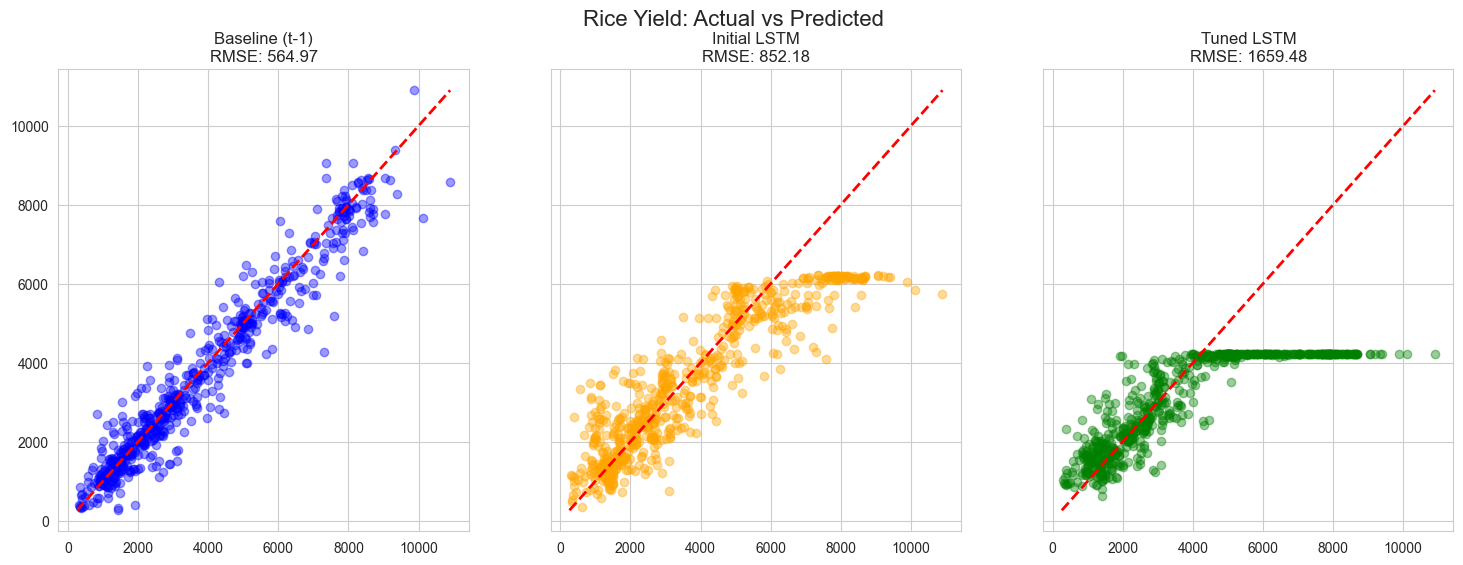

In [32]:
# Calculate Improvement %
imp_final = (rmse_baseline - rmse_final_test) / rmse_baseline * 100

print("--- Final Performance Report (Test Set) ---")
print(f"Baseline RMSE: {rmse_baseline:.2f} (R2: {r2_baseline:.4f})")
print(f"Initial LSTM:  RMSE={rmse_init_test:.2f}")
print(f"Tuned LSTM:    RMSE={rmse_final_test:.2f}, R2={r2_final_test:.4f} (Improved {imp_final:.2f}%)")

# --- PLOTTING RESULTS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Axis Limits
all_preds = np.concatenate([y_pred_baseline, y_pred_init_test, y_pred_final_test])
all_true = np.concatenate([y_test, y_test, y_test])
min_val, max_val = min(min(all_preds), min(all_true)), max(max(all_preds), max(all_true))

# 1. Baseline Plot
axes[0].scatter(y_test, y_pred_baseline, alpha=0.4, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(f'Baseline (t-1)\nRMSE: {rmse_baseline:.2f}')

# 2. Initial Model Plot
axes[1].scatter(y_test, y_pred_init_test, alpha=0.4, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(f'Initial LSTM\nRMSE: {rmse_init_test:.2f}')

# 3. Tuned Model Plot
axes[2].scatter(y_test, y_pred_final_test, alpha=0.4, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[2].set_title(f'Tuned LSTM\nRMSE: {rmse_final_test:.2f}')

plt.suptitle(f'{CHOSEN_CROP.capitalize()} Yield: Actual vs Predicted', fontsize=16)
plt.show()

In [33]:
# --- FULL TIMELINE PLOT ---
import matplotlib.pyplot as plt

# 1. Generate Predictions for all sequenced data
X_all_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)

final_model.eval()
with torch.no_grad():
    all_predictions = final_model(X_all_tensor).cpu().numpy().flatten()

# 2. Create DataFrame
# Note: y_years is the array of target years matching X_seq indices
df_full_trend = pd.DataFrame({
    'Year': y_years,
    'Actual': y_seq,
    'Predicted': all_predictions
})

# Aggregate by Year
yearly_trend = df_full_trend.groupby('Year').mean()

# 3. Plotting
plt.figure(figsize=(14, 7))

# Plot Lines
plt.plot(yearly_trend.index, yearly_trend['Actual'], 
         marker='o', label='Actual Yield', linewidth=2, color='blue')
plt.plot(yearly_trend.index, yearly_trend['Predicted'], 
         marker='x', linestyle='--', label='Predicted Yield', linewidth=2, color='orange')

# Define Split Boundaries
MIN_YEAR = yearly_trend.index.min()
MAX_YEAR = yearly_trend.index.max()
train_boundary = TRAIN_END_YEAR - 0.5
val_boundary = VAL_END_YEAR - 0.5

# --- Highlight Periods ---
plt.axvspan(MIN_YEAR - 0.5, train_boundary, color='green', alpha=0.1, label=f'Train (<{TRAIN_END_YEAR})')
plt.axvspan(train_boundary, val_boundary, color='yellow', alpha=0.1, label=f'Validation ({TRAIN_END_YEAR}-{VAL_END_YEAR - 1})')
plt.axvspan(val_boundary, MAX_YEAR + 0.5, color='red', alpha=0.1, label=f'Test (>={VAL_END_YEAR})')

# Add Text Labels
y_max = yearly_trend['Actual'].max()
text_y = y_max * 1.05 

plt.text((MIN_YEAR + train_boundary)/2, text_y, 'TRAINING', ha='center', fontsize=12, fontweight='bold', color='green')
plt.text((train_boundary + val_boundary)/2, text_y, 'VALIDATION', ha='center', fontsize=12, fontweight='bold', color='#D4AC0D')
plt.text((val_boundary + MAX_YEAR)/2, text_y, 'TESTING', ha='center', fontsize=12, fontweight='bold', color='red')

# Final Formatting
plt.title(f'Full Timeline Analysis: Actual vs. Predicted Yield ({CHOSEN_CROP})', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yield (hg/ha)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(MIN_YEAR, MAX_YEAR + 1, 2))
plt.xlim(MIN_YEAR - 0.5, MAX_YEAR + 0.5)

plt.tight_layout()
plt.show()

NameError: name 'y_years' is not defined

* **Geographic Error:** We map the error rates by country to see where the model performs best and where it struggles.

In [ ]:
import plotly.express as px

# Prepare Data for Map (re-using the area names stored during sequence creation)
comparison_df = pd.DataFrame({
    'area': test_areas,
    'Actual_Value': y_test,
    'Predicted_Value': y_pred_final_test
})

# Name Cleaning for Map Plotting
comparison_df['area'] = comparison_df['area'].replace({
    'United_States_of_America': 'United States',
    'United_Kingdom_of_Great_Britain_and_Northern_Ireland': 'United Kingdom',
    'Russian_Federation': 'Russia',
    'Viet_Nam': 'Vietnam',
    'Türkiye': 'Turkey',
    'Bolivia_(Plurinational_State_of)': 'Bolivia',
    'Iran_(Islamic_Republic_of)': 'Iran',
    "Lao_People's_Democratic_Republic": 'Laos',
    'China,_mainland': 'China',
    'China,_Taiwan_Province_of': 'Taiwan',
    "Democratic_People's_Republic_of_Korea": 'North Korea',
    'Republic_of_Korea': 'South Korea',
    'Côte_d\'Ivoire': "Cote d'Ivoire",
    'United_Republic_of_Tanzania': 'Tanzania',
    'Micronesia_(Federated_States_of)': 'Micronesia',
    'Venezuela_(Bolivarian_Republic_of)': 'Venezuela'
})

def plot_geographic_error(comparison_df):
    # Squared Error (for RMSE)
    comparison_df['Squared_Error'] = (comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) ** 2
    # Squared Percentage Error (for RMSPE)
    epsilon = 1e-6 
    comparison_df['Squared_Percentage_Error'] = (
        (comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) / 
        (comparison_df['Actual_Value'] + epsilon)
    ) ** 2

    # Aggregate Errors by Country
    rmse_df = (
        comparison_df.groupby('area')['Squared_Error']
        .mean().apply(np.sqrt).reset_index()
        .rename(columns={'area': 'Country', 'Squared_Error': 'RMSE'})
    )
    rmspe_df = (
        comparison_df.groupby('area')['Squared_Percentage_Error']
        .mean().apply(np.sqrt).multiply(100).reset_index()
        .rename(columns={'area': 'Country', 'Squared_Percentage_Error': 'RMSPE'})
    )
    ap_df = comparison_df.groupby('area')[['Actual_Value', 'Predicted_Value']].mean().reset_index()
    ap_df = ap_df.rename(columns={'area': 'Country'})

    # Merge stats
    error_stats = rmspe_df.merge(rmse_df, on='Country', how='left')
    error_stats = error_stats.merge(ap_df, on='Country', how='left') 

    # Plot
    fig = px.choropleth(
        error_stats,
        locations='Country',
        color='RMSPE',
        locationmode='country names',
        color_continuous_scale=['green', 'red'], 
        range_color=[0, 50], 
        title='Geographic Distribution of Prediction Error (RMSPE)',
        labels={'RMSPE': 'RMSPE (%)'},
        hover_name='Country',
        hover_data={'RMSPE': ':.2f', 'RMSE': ':.2f', 'Actual_Value': ':.2f', 'Predicted_Value': ':.2f'},
        projection='natural earth'
    )
    fig.update_layout(
        title_font_size=18,
        coloraxis_colorbar=dict(title='RMSPE (%)', orientation='h', len=0.5, yanchor='bottom', y=-0.12),
        geo=dict(showframe=False, showcoastlines=True, showcountries=True, countrycolor='black', bgcolor='lightgrey')
    )
    fig.show()

plot_geographic_error(comparison_df)

### 9. Key Factors (Feature Importance)
For LSTMs, Permutation Importance can be calculated by shuffling the feature values across all time steps in the sequences.

In [ ]:
# --- WRAPPER FOR SKLEARN COMPATIBILITY ---
class PyTorchEstimator:
    """
    Wrapper to make PyTorch LSTM model behave like a Sklearn estimator.
    Handles 3D input shuffling logic for permutation_importance.
    """
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def fit(self, X, y):
        pass # Model is already trained

    def predict(self, X):
        # X is (N, seq_len, features) if passed correctly
        # Sklearn might pass X as 2D if we don't handle shapes carefully,
        # but here we pass the 3D validation set directly.
        
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            preds = self.model(X_tensor).cpu().numpy().flatten()
        return preds

# --- CALCULATE PERMUTATION IMPORTANCE ---
# We pass the 3D validation data (X_val) directly.
# Sklearn's permutation_importance creates copies and shuffles columns.
# For 3D arrays, Sklearn flattens the first dim if not careful, 
# but for custom estimators, we need to ensure the permuter understands the shape.
# Since Sklearn standard PI expects 2D, we write a custom manual loop for 3D LSTMs.

def calculate_lstm_feature_importance(model, X, y, feature_names):
    model.eval()
    original_mse = mean_squared_error(y, PyTorchEstimator(model, device).predict(X))
    importances = []
    
    for i in range(X.shape[2]): # Iterate over features
        X_temp = X.copy()
        # Shuffle feature i across all samples and time steps uniformly or per-sample
        # Standard approach: Shuffle the feature column 'i' across the batch dimension
        np.random.shuffle(X_temp[:, :, i]) 
        
        perm_mse = mean_squared_error(y, PyTorchEstimator(model, device).predict(X_temp))
        # Importance = increase in error
        importances.append(perm_mse - original_mse)
        
    return pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Calculate
fi_df = calculate_lstm_feature_importance(final_model, X_val, y_val, feature_cols)
fi_df = fi_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print Top 20
print("\n--- Top 20 Most Important Features (LSTM Permutation) ---")
print(fi_df.head(20))

# --- PLOT ---
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(20), palette='viridis')
plt.title(f'Feature Importance (Permutation) - {CHOSEN_CROP.capitalize()} LSTM', fontsize=15)
plt.xlabel('Increase in MSE when shuffled')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()